In [ ]:
!pip install face_recognition

In [ ]:
#before running this please change the RUNTIME to GPU (Runtime -> Change runtime type -> set harware accelarotor as GPU)
#Mount our google drive
from google.colab import drive
drive.mount('/content/drive')

# 1. Setup and Imports

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
from torch import nn
from torchvision import models, transforms
from torch.utils.data import Dataset
import face_recognition

# 2. Load the Model
We need to load the model with the same architecture as used during training and then load the saved weights.

In [ ]:
class Model(nn.Module):
    def __init__(self, num_classes, latent_dim=2048, lstm_layers=1, hidden_dim=2048, bidirectional=False):
        super(Model, self).__init__()
        model = models.resnext50_32x4d(pretrained=True)
        self.model = nn.Sequential(*list(model.children())[:-2])
        self.lstm = nn.LSTM(latent_dim, hidden_dim, lstm_layers, bidirectional=bidirectional)
        self.dp = nn.Dropout(0.4)
        self.linear1 = nn.Linear(hidden_dim, num_classes)
        self.avgpool = nn.AdaptiveAvgPool2d(1)

    def forward(self, x):
        batch_size, seq_length, c, h, w = x.shape
        x = x.view(batch_size * seq_length, c, h, w)
        fmap = self.model(x)
        x = self.avgpool(fmap)
        x = x.view(batch_size, seq_length, -1)
        x_lstm, _ = self.lstm(x)
        x = self.dp(self.linear1(torch.mean(x_lstm, dim=1)))
        return fmap, x

# 3. Prepare the Data
We need to prepare the video data in the same way as during training. This means extracting frames from the video, applying the same transformations, and creating a batch (or using a single sequence if our model can handle variable-length inputs).

## 3.1 Define the Dataset Class

In [ ]:
sm = nn.Softmax(dim=1)

inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)

class validation_dataset(Dataset):
    def __init__(self, video_names, sequence_length=60, transform=None):
        self.video_names = video_names
        self.transform = transform
        self.count = sequence_length

    def __len__(self):
        return len(self.video_names)

    def __getitem__(self, idx):
        video_path = self.video_names[idx]
        cap = cv2.VideoCapture(video_path)
        cropped_faces, original_frames, raw_cropped_faces = [], [], []
        frame_count = 0
        while frame_count < self.count:
            success, frame = cap.read()
            if not success:
                break
            original_frames.append(frame.copy())
            faces = face_recognition.face_locations(frame)
            if faces:
                top, right, bottom, left = faces[0]
                cropped = frame[top:bottom, left:right]
                raw_cropped_faces.append(cropped)  # Save the untransformed cropped face
                if self.transform:
                    cropped = self.transform(cropped)
                cropped_faces.append(cropped)
            frame_count += 1
        cap.release()
        frames_tensor = torch.stack(cropped_faces) if cropped_faces else None
        return frames_tensor, original_frames, raw_cropped_faces

## 3.2 Define the Inference Function

In [ ]:
def predict(model, img, path='./'):
    model.eval()  # Ensure the model is in evaluation mode

    # Add an extra dimension to img tensor to represent batch size
    if len(img.shape) == 4:  # Check if the tensor is 4D
        img = img.unsqueeze(0)  # Add the batch dimension

    # Move the input tensor to the same device as the model
    img = img.to(next(model.parameters()).device)

    with torch.no_grad():  # Ensure no gradients are calculated
        fmap, logits = model(img)
        logits = sm(logits)
        _, prediction = torch.max(logits, 1)
        confidence = logits[:, int(prediction.item())].item() * 100

    # print(f'Confidence of prediction: {confidence}%')
    return prediction.item(), confidence


im_size = 112
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((im_size, im_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

# 3. Make the Prediction

In [ ]:
model = Model(num_classes=2).cude()
model_path = '/content/drive/MyDrive/model_93_acc_100_frames_celeb_FF_data.pt'
model.load_state_dict(torch.load(model_path))
model.eval()

video_paths = ['/content/drive/MyDrive/Final Year Project/validation_set/eukvucdetx.mp4',
               '/content/drive/MyDrive/Final Year Project/validation_set/eudeqjhdfd.mp4',
               '/content/drive/MyDrive/Final Year Project/validation_set/etohcvnzbj.mp4']

val_dataset = validation_dataset(video_paths, sequence_length=10, transform=transform)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNeXt50_32X4D_Weights.IMAGENET1K_V1`. You can also use `weights=ResNeXt50_32X4D_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth" to /root/.cache/torch/hub/checkpoints/resnext50_32x4d-7cdf4587.pth
100%|██████████| 95.8M/95.8M [00:00<00:00, 156MB/s]


AttributeError: 'Model' object has no attribute 'cude'

In [ ]:
for i in range(len(val_dataset)):
    video_tensor, original_frames, raw_cropped_faces = val_dataset[i]
    if video_tensor is not None:
        video_tensor = video_tensor.cuda()
        prediction, confidence = predict(model, video_tensor)
        label = 'REAL' if prediction == 1 else 'FAKE'

    last_frame = original_frames[-1]
    cropped_face = raw_cropped_faces[0] if raw_cropped_faces else None

    if cropped_face is not None:
        fig, axs = plt.subplots(1, 2, figsize=(12, 6))
        axs[0].imshow(cv2.cvtColor(last_frame, cv2.COLOR_BGR2RGB))
        axs[0].set_title('Frame')
        axs[0].axis('off')

        axs[1].imshow(cv2.cvtColor(cropped_face, cv2.COLOR_BGR2RGB))
        axs[1].set_title('Cropped Face')
        axs[1].axis('off')

        plt.suptitle(f'Prediction: {label}, Confidence: {confidence:.2f}%')
        plt.show()

NameError: name 'val_dataset' is not defined

# All Code

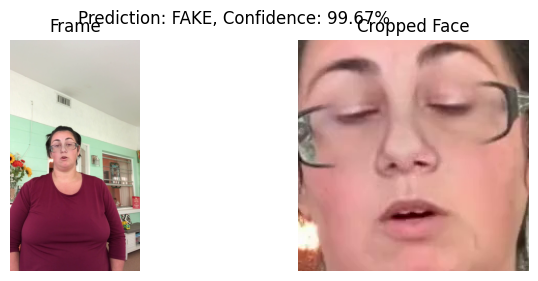

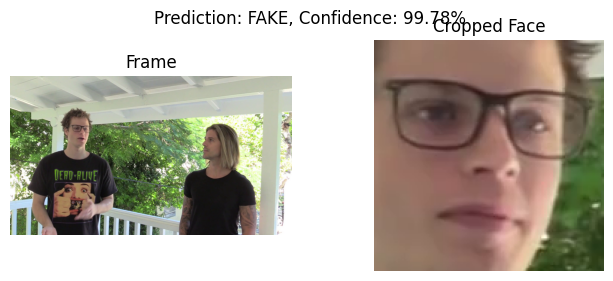

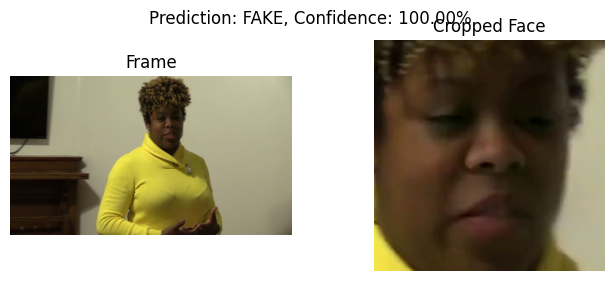

No frames to process in video /content/drive/MyDrive/Final Year Project/validation_set/axwgcsyphv.mp4


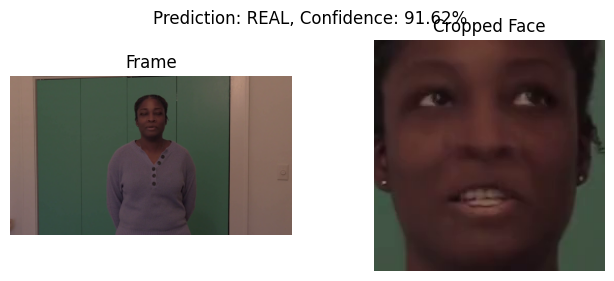

No frames to process in video /content/drive/MyDrive/Final Year Project/validation_set/abofeumbvv.mp4


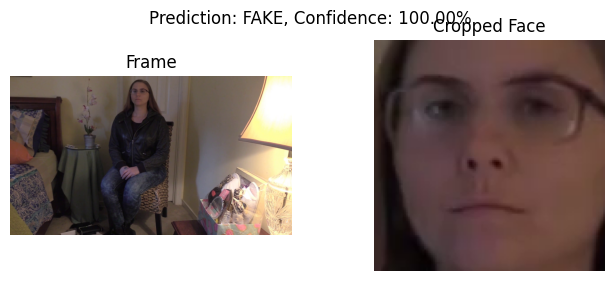

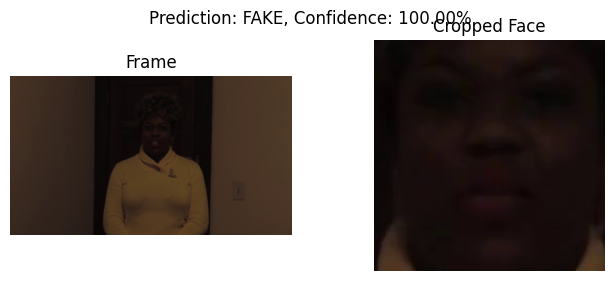

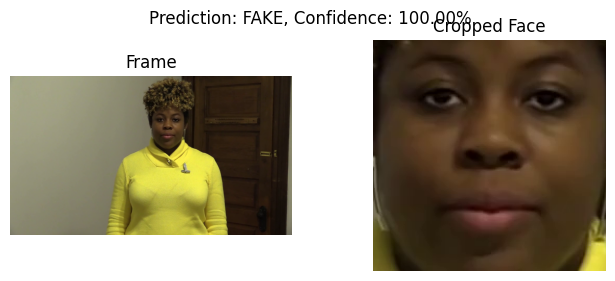

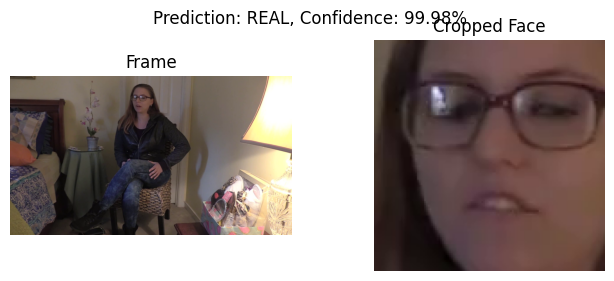

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
from torch import nn
from torchvision import models, transforms
from torch.utils.data import Dataset
import face_recognition

class Model(nn.Module):
    def __init__(self, num_classes, latent_dim=2048, lstm_layers=1, hidden_dim=2048, bidirectional=False):
        super(Model, self).__init__()
        model = models.resnext50_32x4d(weights='DEFAULT')
        self.model = nn.Sequential(*list(model.children())[:-2])
        self.lstm = nn.LSTM(latent_dim, hidden_dim, lstm_layers, bidirectional=bidirectional)
        self.dp = nn.Dropout(0.4)
        self.linear1 = nn.Linear(hidden_dim, num_classes)
        self.avgpool = nn.AdaptiveAvgPool2d(1)

    def forward(self, x):
        batch_size, seq_length, c, h, w = x.shape
        x = x.view(batch_size * seq_length, c, h, w)
        fmap = self.model(x)
        x = self.avgpool(fmap)
        x = x.view(batch_size, seq_length, -1)
        x_lstm, _ = self.lstm(x)
        x = self.dp(self.linear1(torch.mean(x_lstm, dim=1)))
        return fmap, x

sm = nn.Softmax(dim=1)

inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)

class validation_dataset(Dataset):
    def __init__(self, video_names, sequence_length=60, transform=None):
        self.video_names = video_names
        self.transform = transform
        self.count = sequence_length

    def __len__(self):
        return len(self.video_names)

    def __getitem__(self, idx):
        video_path = self.video_names[idx]
        cap = cv2.VideoCapture(video_path)
        cropped_faces, original_frames, raw_cropped_faces = [], [], []
        frame_count = 0
        while frame_count < self.count:
            success, frame = cap.read()
            if not success:
                break
            original_frames.append(frame.copy())
            faces = face_recognition.face_locations(frame)
            if faces:
                top, right, bottom, left = faces[0]
                cropped = frame[top:bottom, left:right]
                raw_cropped_faces.append(cropped)  # Save the untransformed cropped face
                if self.transform:
                    cropped = self.transform(cropped)
                cropped_faces.append(cropped)
            frame_count += 1
        cap.release()
        frames_tensor = torch.stack(cropped_faces) if cropped_faces else None
        return frames_tensor, original_frames, raw_cropped_faces

def predict(model, img, path='./'):
    model.eval()  # Ensure the model is in evaluation mode

    # Add an extra dimension to img tensor to represent batch size
    if len(img.shape) == 4:  # Check if the tensor is 4D
        img = img.unsqueeze(0)  # Add the batch dimension

    # Move the input tensor to the same device as the model
    img = img.to(next(model.parameters()).device)

    with torch.no_grad():  # Ensure no gradients are calculated
        fmap, logits = model(img)
        logits = sm(logits)
        _, prediction = torch.max(logits, 1)
        confidence = logits[:, int(prediction.item())].item() * 100

    # print(f'Confidence of prediction: {confidence}%')
    return prediction.item(), confidence


im_size = 112
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((im_size, im_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

# Determine if a GPU is available and use it, otherwise fallback to CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Instantiate the model
model = Model(num_classes=2)
# Load your custom model's state dict
model_path = '/content/drive/MyDrive/Colab Notebooks/model_90_acc_80_frames.pt'
model.load_state_dict(torch.load(model_path, map_location=device))
# Move the model to the appropriate device
model = model.to(device)
# Set the model to evaluation mode
model.eval()

video_paths = [



                           '/content/drive/MyDrive/Final Year Project/validation_set/alvgwypubw.mp4',
               '/content/drive/MyDrive/Final Year Project/validation_set/apatcsqejh.mp4',
               '/content/drive/MyDrive/Final Year Project/validation_set/avfitoutyn.mp4',
               '/content/drive/MyDrive/Final Year Project/validation_set/axwgcsyphv.mp4',
               '/content/drive/MyDrive/Final Year Project/validation_set/bnjcdrfuov.mp4',
               #'/content/drive/MyDrive/Final Year Project/validation_set/adylbeequz.mp4',

              '/content/drive/MyDrive/Final Year Project/validation_set/abofeumbvv.mp4',
               '/content/drive/MyDrive/Final Year Project/validation_set/ajwpjhrbcv.mp4',
               '/content/drive/MyDrive/Final Year Project/validation_set/bgaogsjehq.mp4',
               '/content/drive/MyDrive/Final Year Project/validation_set/bydaidkpdp.mp4',
               '/content/drive/MyDrive/Final Year Project/validation_set/dbtbbhakdv.mp4'


               ]
val_dataset = validation_dataset(video_paths, sequence_length=10, transform=transform)


for i in range(len(val_dataset)):
    video_tensor, original_frames, raw_cropped_faces = val_dataset[i]
    if video_tensor is not None and len(original_frames) > 0:
        video_tensor = video_tensor.cuda()
        prediction, confidence = predict(model, video_tensor)
        label = 'REAL' if prediction == 1 else 'FAKE'
        last_frame = original_frames[-1]
        cropped_face = raw_cropped_faces[0] if raw_cropped_faces else None

        if cropped_face is not None:
            fig, axs = plt.subplots(1, 2, figsize=(8, 3))
            axs[0].imshow(cv2.cvtColor(last_frame, cv2.COLOR_BGR2RGB))
            axs[0].set_title('Frame')
            axs[0].axis('off')

            axs[1].imshow(cv2.cvtColor(cropped_face, cv2.COLOR_BGR2RGB))
            axs[1].set_title('Cropped Face')
            axs[1].axis('off')

            plt.suptitle(f'Prediction: {label}, Confidence: {confidence:.2f}%')
            plt.show()
    else:
        print(f"No frames to process in video {val_dataset.video_names[i]}")

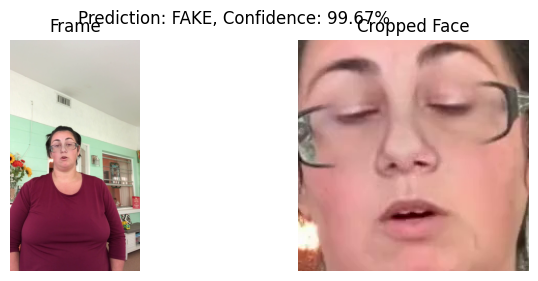

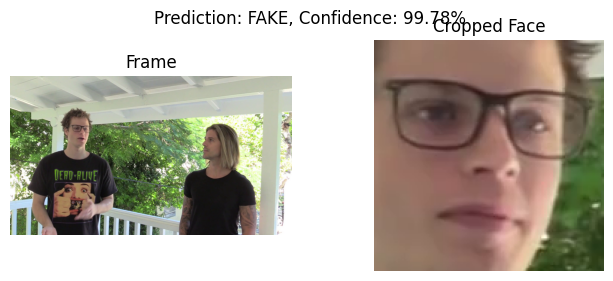

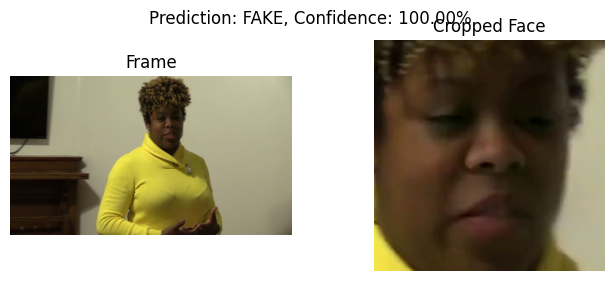

No frames to process in video /content/drive/MyDrive/Final Year Project/validation_set/axwgcsyphv.mp4


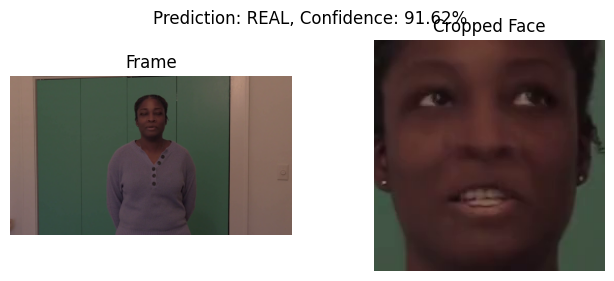

No frames to process in video /content/drive/MyDrive/Final Year Project/validation_set/abofeumbvv.mp4


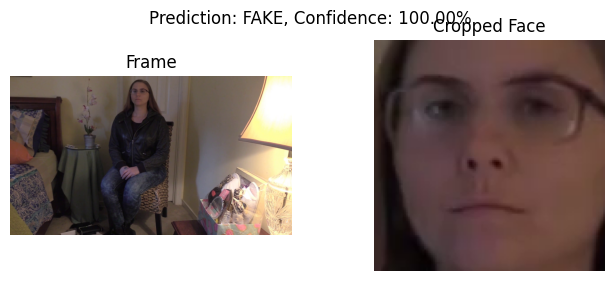

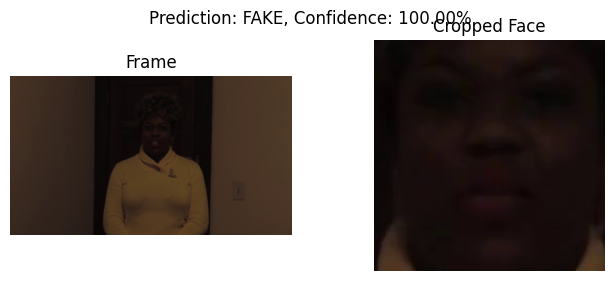

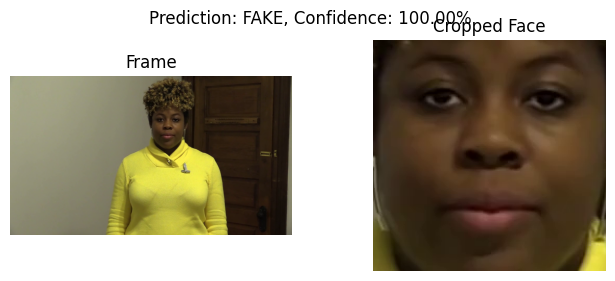

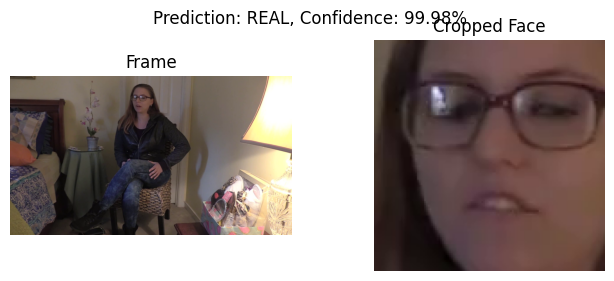

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
from torch import nn
from torchvision import models, transforms
from torch.utils.data import Dataset
import face_recognition

class Model(nn.Module):
    def __init__(self, num_classes, latent_dim=2048, lstm_layers=1, hidden_dim=2048, bidirectional=False):
        super(Model, self).__init__()
        model = models.resnext50_32x4d(weights='DEFAULT')
        self.model = nn.Sequential(*list(model.children())[:-2])
        self.lstm = nn.LSTM(latent_dim, hidden_dim, lstm_layers, bidirectional=bidirectional)
        self.dp = nn.Dropout(0.4)
        self.linear1 = nn.Linear(hidden_dim, num_classes)
        self.avgpool = nn.AdaptiveAvgPool2d(1)

    def forward(self, x):
        batch_size, seq_length, c, h, w = x.shape
        x = x.view(batch_size * seq_length, c, h, w)
        fmap = self.model(x)
        x = self.avgpool(fmap)
        x = x.view(batch_size, seq_length, -1)
        x_lstm, _ = self.lstm(x)
        x = self.dp(self.linear1(torch.mean(x_lstm, dim=1)))
        return fmap, x

sm = nn.Softmax(dim=1)

inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)

class validation_dataset(Dataset):
    def __init__(self, video_names, sequence_length=60, transform=None):
        self.video_names = video_names
        self.transform = transform
        self.count = sequence_length

    def __len__(self):
        return len(self.video_names)

    def __getitem__(self, idx):
        video_path = self.video_names[idx]
        cap = cv2.VideoCapture(video_path)
        cropped_faces, original_frames, raw_cropped_faces = [], [], []
        frame_count = 0
        while frame_count < self.count:
            success, frame = cap.read()
            if not success:
                break
            original_frames.append(frame.copy())
            faces = face_recognition.face_locations(frame)
            if faces:
                top, right, bottom, left = faces[0]
                cropped = frame[top:bottom, left:right]
                raw_cropped_faces.append(cropped)  # Save the untransformed cropped face
                if self.transform:
                    cropped = self.transform(cropped)
                cropped_faces.append(cropped)
            frame_count += 1
        cap.release()
        frames_tensor = torch.stack(cropped_faces) if cropped_faces else None
        return frames_tensor, original_frames, raw_cropped_faces

def predict(model, img, path='./'):
    model.eval()  # Ensure the model is in evaluation mode

    # Add an extra dimension to img tensor to represent batch size
    if len(img.shape) == 4:  # Check if the tensor is 4D
        img = img.unsqueeze(0)  # Add the batch dimension

    # Move the input tensor to the same device as the model
    img = img.to(next(model.parameters()).device)

    with torch.no_grad():  # Ensure no gradients are calculated
        fmap, logits = model(img)
        logits = sm(logits)
        _, prediction = torch.max(logits, 1)
        confidence = logits[:, int(prediction.item())].item() * 100

    # print(f'Confidence of prediction: {confidence}%')
    return prediction.item(), confidence


im_size = 112
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((im_size, im_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

# Determine if a GPU is available and use it, otherwise fallback to CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Instantiate the model
model = Model(num_classes=2)
# Load your custom model's state dict
model_path = '/content/drive/MyDrive/Colab Notebooks/model_90_acc_80_frames.pt'
model.load_state_dict(torch.load(model_path, map_location=device))
# Move the model to the appropriate device
model = model.to(device)
# Set the model to evaluation mode
model.eval()

video_paths = [


              '/content/drive/MyDrive/Final Year Project/validation_set/alvgwypubw.mp4',
               '/content/drive/MyDrive/Final Year Project/validation_set/apatcsqejh.mp4',
               '/content/drive/MyDrive/Final Year Project/validation_set/avfitoutyn.mp4',
               '/content/drive/MyDrive/Final Year Project/validation_set/axwgcsyphv.mp4',
               '/content/drive/MyDrive/Final Year Project/validation_set/bnjcdrfuov.mp4',
               #'/content/drive/MyDrive/Final Year Project/validation_set/adylbeequz.mp4',

              '/content/drive/MyDrive/Final Year Project/validation_set/abofeumbvv.mp4',
               '/content/drive/MyDrive/Final Year Project/validation_set/ajwpjhrbcv.mp4',
               '/content/drive/MyDrive/Final Year Project/validation_set/bgaogsjehq.mp4',
               '/content/drive/MyDrive/Final Year Project/validation_set/bydaidkpdp.mp4',
               '/content/drive/MyDrive/Final Year Project/validation_set/dbtbbhakdv.mp4',
               #'/content/drive/MyDrive/Final Year Project/validation_set/etmcruaihe.mp4',
                # '/content/drive/MyDrive/Final Year Project/validation_set/bahdpoesir.mp4',
               #'/content/drive/MyDrive/Final Year Project/validation_set/bchnbulevv.mp4'


               ]
val_dataset = validation_dataset(video_paths, sequence_length=10, transform=transform)


for i in range(len(val_dataset)):
    video_tensor, original_frames, raw_cropped_faces = val_dataset[i]
    if video_tensor is not None and len(original_frames) > 0:
        video_tensor = video_tensor.cuda()
        prediction, confidence = predict(model, video_tensor)
        label = 'REAL' if prediction == 1 else 'FAKE'
        last_frame = original_frames[-1]
        cropped_face = raw_cropped_faces[0] if raw_cropped_faces else None

        if cropped_face is not None:
            fig, axs = plt.subplots(1, 2, figsize=(8, 3))
            axs[0].imshow(cv2.cvtColor(last_frame, cv2.COLOR_BGR2RGB))
            axs[0].set_title('Frame')
            axs[0].axis('off')

            axs[1].imshow(cv2.cvtColor(cropped_face, cv2.COLOR_BGR2RGB))
            axs[1].set_title('Cropped Face')
            axs[1].axis('off')

            plt.suptitle(f'Prediction: {label}, Confidence: {confidence:.2f}%')
            plt.show()
    else:
        print(f"No frames to process in video {val_dataset.video_names[i]}")

## V2

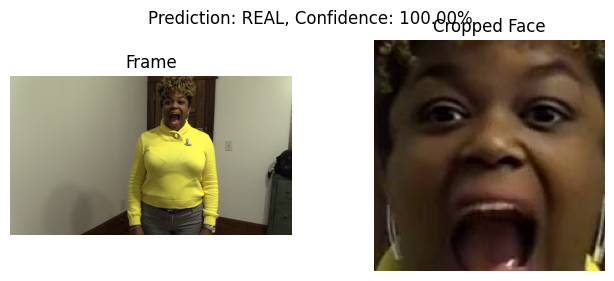

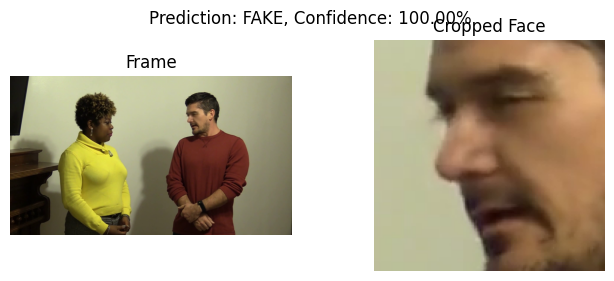

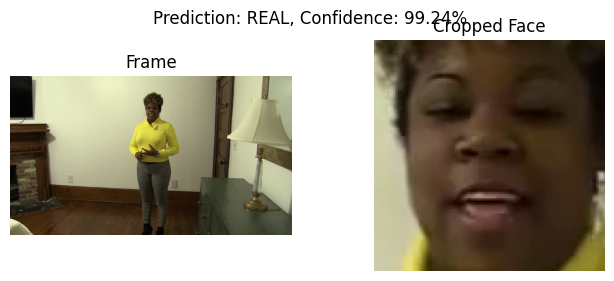

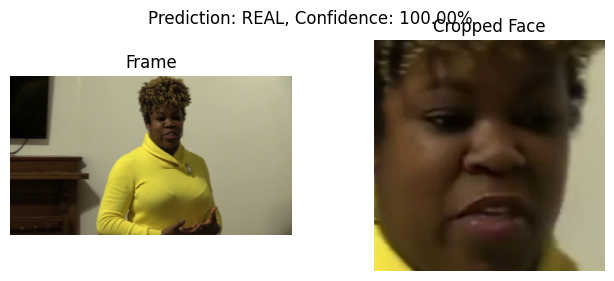

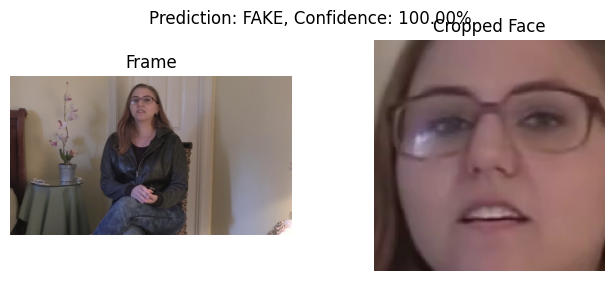

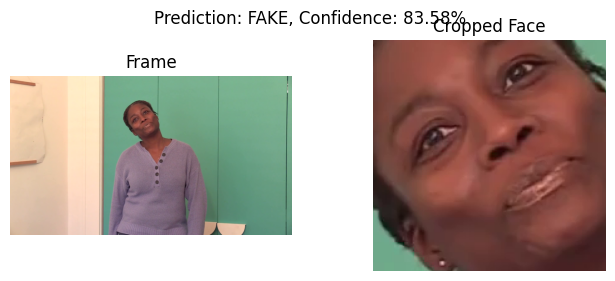

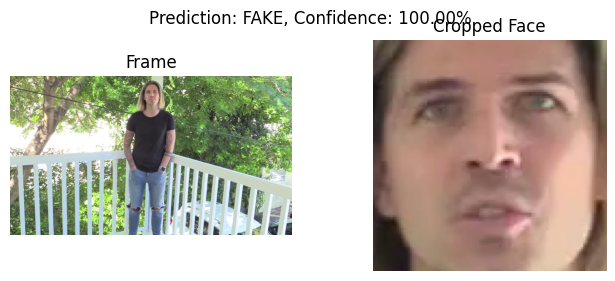

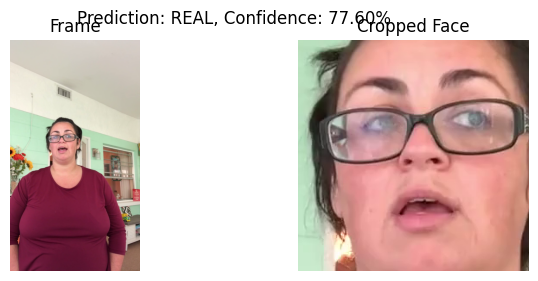

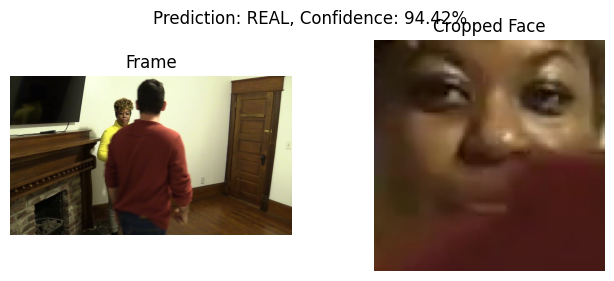

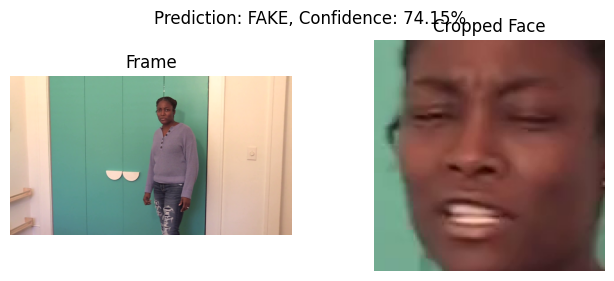

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
from torch import nn
from torchvision import models, transforms
from torch.utils.data import Dataset
import face_recognition

class Model(nn.Module):
    def __init__(self, num_classes, latent_dim=2048, lstm_layers=1, hidden_dim=2048, bidirectional=False):
        super(Model, self).__init__()
        model = models.resnext50_32x4d(weights='DEFAULT')
        self.model = nn.Sequential(*list(model.children())[:-2])
        self.lstm = nn.LSTM(latent_dim, hidden_dim, lstm_layers, bidirectional=bidirectional)
        self.dp = nn.Dropout(0.4)
        self.linear1 = nn.Linear(hidden_dim, num_classes)
        self.avgpool = nn.AdaptiveAvgPool2d(1)

    def forward(self, x):
        batch_size, seq_length, c, h, w = x.shape
        x = x.view(batch_size * seq_length, c, h, w)
        fmap = self.model(x)
        x = self.avgpool(fmap)
        x = x.view(batch_size, seq_length, -1)
        x_lstm, _ = self.lstm(x)
        x = self.dp(self.linear1(torch.mean(x_lstm, dim=1)))
        return fmap, x

sm = nn.Softmax(dim=1)

inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)

class validation_dataset(Dataset):
    def __init__(self, video_names, sequence_length=60, transform=None):
        self.video_names = video_names
        self.transform = transform
        self.count = sequence_length

    def __len__(self):
        return len(self.video_names)

    def __getitem__(self, idx):
        video_path = self.video_names[idx]
        cap = cv2.VideoCapture(video_path)
        cropped_faces, original_frames, raw_cropped_faces = [], [], []
        frame_count = 0
        while frame_count < self.count:
            success, frame = cap.read()
            if not success:
                break
            original_frames.append(frame.copy())
            faces = face_recognition.face_locations(frame)
            if faces:
                top, right, bottom, left = faces[0]
                cropped = frame[top:bottom, left:right]
                raw_cropped_faces.append(cropped)  # Save the untransformed cropped face
                if self.transform:
                    cropped = self.transform(cropped)
                cropped_faces.append(cropped)
            frame_count += 1
        cap.release()
        frames_tensor = torch.stack(cropped_faces) if cropped_faces else None
        return frames_tensor, original_frames, raw_cropped_faces

def predict(model, img, path='./'):
    model.eval()  # Ensure the model is in evaluation mode

    # Add an extra dimension to img tensor to represent batch size
    if len(img.shape) == 4:  # Check if the tensor is 4D
        img = img.unsqueeze(0)  # Add the batch dimension

    # Move the input tensor to the same device as the model
    img = img.to(next(model.parameters()).device)

    with torch.no_grad():  # Ensure no gradients are calculated
        fmap, logits = model(img)
        logits = sm(logits)
        _, prediction = torch.max(logits, 1)
        confidence = logits[:, int(prediction.item())].item() * 100

    # print(f'Confidence of prediction: {confidence}%')
    return prediction.item(), confidence


im_size = 112
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((im_size, im_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

# Determine if a GPU is available and use it, otherwise fallback to CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Instantiate the model
model = Model(num_classes=2)
# Load your custom model's state dict
model_path = '/content/drive/MyDrive/Colab Notebooks/model_90_acc_100_frames_13epoch.pt'
model.load_state_dict(torch.load(model_path, map_location=device))
# Move the model to the appropriate device
model = model.to(device)
# Set the model to evaluation mode
model.eval()

video_paths = [


              '/content/drive/MyDrive/Final Year Project/validation_set/alvgwypubw.mp4',
               '/content/drive/MyDrive/Final Year Project/validation_set/apatcsqejh.mp4',
               '/content/drive/MyDrive/Final Year Project/validation_set/avfitoutyn.mp4',
               '/content/drive/MyDrive/Final Year Project/validation_set/eukvucdetx.mp4',
               '/content/drive/MyDrive/Final Year Project/validation_set/bnjcdrfuov.mp4',
               #'/content/drive/MyDrive/Final Year Project/validation_set/adylbeequz.mp4',

              '/content/drive/MyDrive/Final Year Project/validation_set/bejhvclboh.mp4',
               '/content/drive/MyDrive/Final Year Project/validation_set/abarnvbtwb.mp4',
               '/content/drive/MyDrive/Final Year Project/validation_set/bgaogsjehq.mp4',
               '/content/drive/MyDrive/Final Year Project/validation_set/bydaidkpdp.mp4',
               '/content/drive/MyDrive/Final Year Project/validation_set/dbtbbhakdv.mp4'
               #'/content/drive/MyDrive/Final Year Project/validation_set/etmcruaihe.mp4',
                # '/content/drive/MyDrive/Final Year Project/validation_set/bahdpoesir.mp4',
               #'/content/drive/MyDrive/Final Year Project/validation_set/bchnbulevv.mp4'


               ]
val_dataset = validation_dataset(video_paths, sequence_length=10, transform=transform)

# for i in range(len(val_dataset)):
#     video_tensor, original_frames, raw_cropped_faces = val_dataset[i]
#     if video_tensor is not None:
#         video_tensor = video_tensor.cuda()
#         prediction, confidence = predict(model, video_tensor)
#         label = 'REAL' if prediction == 1 else 'FAKE'

#     last_frame = original_frames[-1]
#     cropped_face = raw_cropped_faces[0] if raw_cropped_faces else None

#     if cropped_face is not None:
#         fig, axs = plt.subplots(1, 2, figsize=(10, 4))
#         axs[0].imshow(cv2.cvtColor(last_frame, cv2.COLOR_BGR2RGB))
#         axs[0].set_title('Frame')
#         axs[0].axis('off')

#         axs[1].imshow(cv2.cvtColor(cropped_face, cv2.COLOR_BGR2RGB))
#         axs[1].set_title('Cropped Face')
#         axs[1].axis('off')

#         plt.suptitle(f'Prediction: {label}, Confidence: {confidence:.2f}%')
#         plt.show()
for i in range(len(val_dataset)):
    video_tensor, original_frames, raw_cropped_faces = val_dataset[i]
    if video_tensor is not None and len(original_frames) > 0:
        video_tensor = video_tensor.cuda()
        prediction, confidence = predict(model, video_tensor)
        label = 'REAL' if prediction == 1 else 'FAKE'
        last_frame = original_frames[-1]
        cropped_face = raw_cropped_faces[0] if raw_cropped_faces else None

        if cropped_face is not None:
            fig, axs = plt.subplots(1, 2, figsize=(8, 3))
            axs[0].imshow(cv2.cvtColor(last_frame, cv2.COLOR_BGR2RGB))
            axs[0].set_title('Frame')
            axs[0].axis('off')

            axs[1].imshow(cv2.cvtColor(cropped_face, cv2.COLOR_BGR2RGB))
            axs[1].set_title('Cropped Face')
            axs[1].axis('off')

            plt.suptitle(f'Prediction: {label}, Confidence: {confidence:.2f}%')
            plt.show()
    else:
        print(f"No frames to process in video {val_dataset.video_names[i]}")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## V1

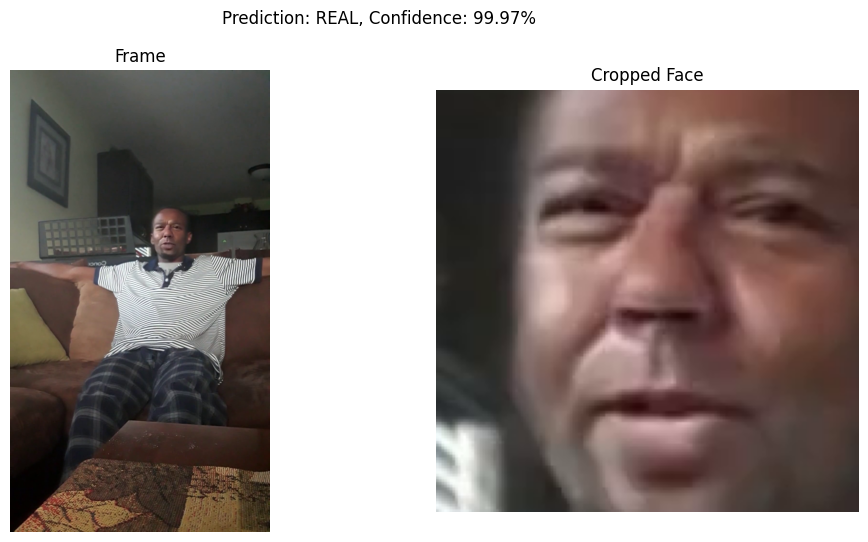

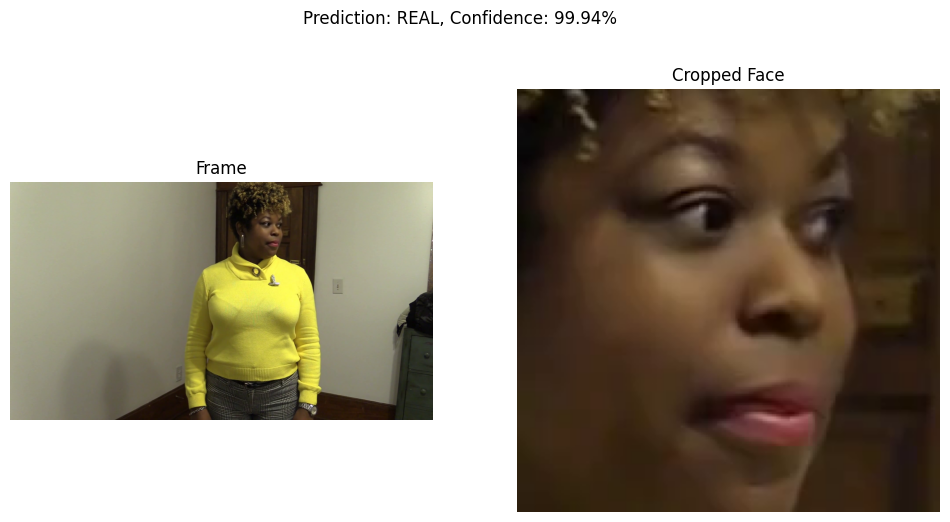

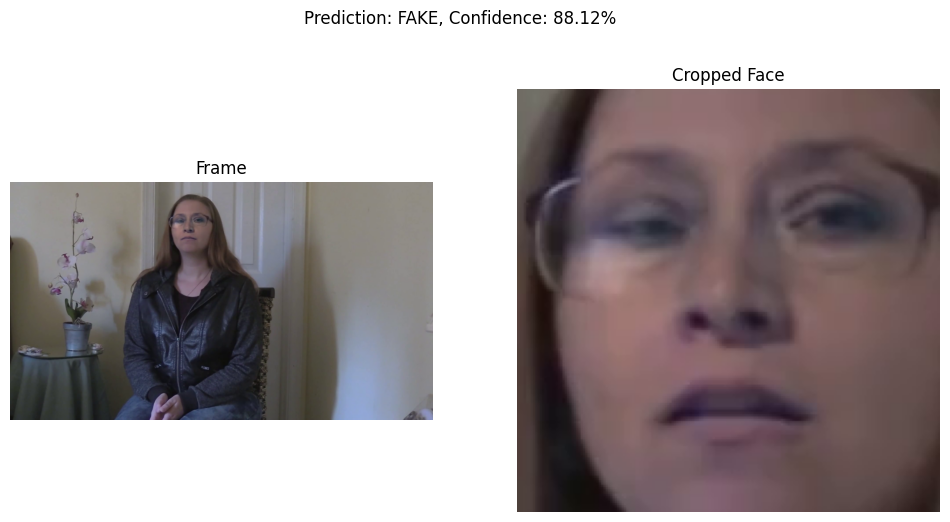

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
from torch import nn
from torchvision import models, transforms
from torch.utils.data import Dataset
import face_recognition

class Model(nn.Module):
    def __init__(self, num_classes,latent_dim= 2048, lstm_layers=1 , hidden_dim = 2048, bidirectional = False):
        super(Model, self).__init__()
        model = models.resnext50_32x4d(pretrained = True)
        self.model = nn.Sequential(*list(model.children())[:-2])
        self.lstm = nn.LSTM(latent_dim,hidden_dim, lstm_layers,  bidirectional)
        self.relu = nn.LeakyReLU()
        self.dp = nn.Dropout(0.4)
        self.linear1 = nn.Linear(2048,num_classes)
        self.avgpool = nn.AdaptiveAvgPool2d(1)
    def forward(self, x):
        batch_size,seq_length, c, h, w = x.shape
        x = x.view(batch_size * seq_length, c, h, w)
        fmap = self.model(x)
        x = self.avgpool(fmap)
        x = x.view(batch_size,seq_length,2048)
        x_lstm,_ = self.lstm(x,None)
        return fmap,self.dp(self.linear1(x_lstm[:,-1,:]))

sm = nn.Softmax(dim=1)

inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)

class validation_dataset(Dataset):
    def __init__(self, video_names, sequence_length=60, transform=None):
        self.video_names = video_names
        self.transform = transform
        self.count = sequence_length

    def __len__(self):
        return len(self.video_names)

    def __getitem__(self, idx):
        video_path = self.video_names[idx]
        cap = cv2.VideoCapture(video_path)
        cropped_faces, original_frames, raw_cropped_faces = [], [], []
        frame_count = 0
        while frame_count < self.count:
            success, frame = cap.read()
            if not success:
                break
            original_frames.append(frame.copy())
            faces = face_recognition.face_locations(frame)
            if faces:
                top, right, bottom, left = faces[0]
                cropped = frame[top:bottom, left:right]
                raw_cropped_faces.append(cropped)  # Save the untransformed cropped face
                if self.transform:
                    cropped = self.transform(cropped)
                cropped_faces.append(cropped)
            frame_count += 1
        cap.release()
        frames_tensor = torch.stack(cropped_faces) if cropped_faces else None
        return frames_tensor, original_frames, raw_cropped_faces

def predict(model, img, path='./'):
    model.eval()  # Ensure the model is in evaluation mode

    # Add an extra dimension to img tensor to represent batch size
    if len(img.shape) == 4:  # Check if the tensor is 4D
        img = img.unsqueeze(0)  # Add the batch dimension

    # Move the input tensor to the same device as the model
    img = img.to(next(model.parameters()).device)

    with torch.no_grad():  # Ensure no gradients are calculated
        fmap, logits = model(img)
        logits = sm(logits)
        _, prediction = torch.max(logits, 1)
        confidence = logits[:, int(prediction.item())].item() * 100

    # print(f'Confidence of prediction: {confidence}%')
    return prediction.item(), confidence


im_size = 112
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((im_size, im_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])


# Determine if a GPU is available and use it, otherwise fallback to CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Instantiate the model
model = Model(num_classes=2)

# Load your custom model's state dict
model_path = '/content/drive/MyDrive/model_93_acc_100_frames_celeb_FF_data.pt'
model.load_state_dict(torch.load(model_path, map_location=device))

# Move the model to the appropriate device
model = model.to(device)

# Set the model to evaluation mode
model.eval()

video_paths = [ '/content/drive/MyDrive/Final Year Project/validation_set/aladcziidp.mp4',
               '/content/drive/MyDrive/Final Year Project/validation_set/agdkmztvby.mp4',
               '/content/drive/MyDrive/Final Year Project/validation_set/adylbeequz.mp4']
val_dataset = validation_dataset(video_paths, sequence_length=10, transform=transform)

for i in range(len(val_dataset)):
    video_tensor, original_frames, raw_cropped_faces = val_dataset[i]
    if video_tensor is not None and len(original_frames) > 0:
        video_tensor = video_tensor.cuda()
        prediction, confidence = predict(model, video_tensor)
        label = 'REAL' if prediction == 1 else 'FAKE'
        last_frame = original_frames[-1]
        cropped_face = raw_cropped_faces[0] if raw_cropped_faces else None

        if cropped_face is not None:
            fig, axs = plt.subplots(1, 2, figsize=(12, 6))
            axs[0].imshow(cv2.cvtColor(last_frame, cv2.COLOR_BGR2RGB))
            axs[0].set_title('Frame')
            axs[0].axis('off')

            axs[1].imshow(cv2.cvtColor(cropped_face, cv2.COLOR_BGR2RGB))
            axs[1].set_title('Cropped Face')
            axs[1].axis('off')

            plt.suptitle(f'Prediction: {label}, Confidence: {confidence:.2f}%')
            plt.show()
    else:
        print(f"No frames to process in video {val_dataset.video_names[i]}")
